# Gaussian Mixture Models

The *k*-means clustering model is simple and easy to understand, but its simplicity leads to challenges. For example,  the non-probabilistic nature of *k*-means and its __simple distance-from-cluster-center__ to assign cluster membership leads to poor performance for many real-world situations.

Let's review __Gaussian mixture models (GMMs)__, which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Motivating GMM: Weaknesses of k-Means

Given simple, well-separated data, *k*-means finds suitable clustering results.

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

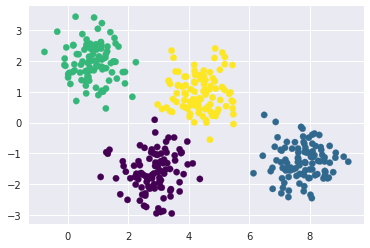

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Think of *k*-means as having a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. The radius acts as a hard cutoff for cluster assignment within the training set.

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

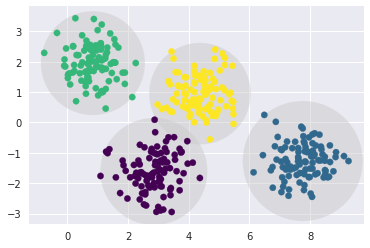

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

The __*k*-means cluster models must be circular__. *k*-means has no built-in way of handling oblong or elliptical clusters. If we transform this same data the cluster assignments become muddled.

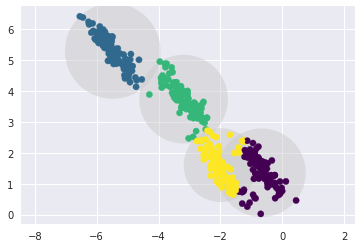

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

*k*-means is not sufficiently flexible and __tries to force-fit the data into four circular clusters__. This results in a mixing of cluster assignments where the resulting circles overlap - see the bottom-right of this plot.

You could try preprocessing the data with PCA to solve this problem. But __there's no guarantee that such a global operation will 'circularize' the data.__

These two disadvantages of *k*-means mean that for many datasets (especially low-dimensional ones) it may not perform as well as you might hope.

To fix these problems, you could measure uncertainty in cluster assignment by __comparing the distances of each point to *all* cluster centers__, rather than just the closest. Also __allowing cluster boundaries to be ellipses rather than circles could help.__

These are two components of Gaussian mixture models.

### Generalizing E–M: Gaussian Mixture Models

- Gaussian mixture models (GMMs) attempt to find a mix of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can find clusters in the same manner as *k*-means:

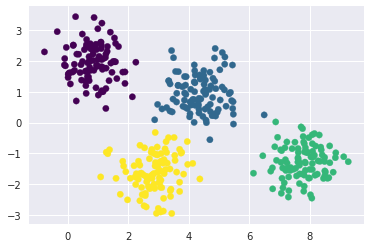

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

GMM contains a probabilistic model under the hood, so it's possible to find probabilistic cluster assignments using Scikit's ``predict_proba`` method. 

It returns a matrix of size ``[n_samples, n_clusters]`` which __measures the probability that any point belongs to the given cluster.__

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[ 0.     0.531  0.469  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     0.     1.   ]]


We can see this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction. 

We can see that it is the points at the boundaries between clusters that reflect this uncertainty of cluster assignment.

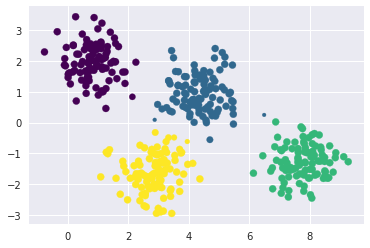

In [9]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

A GMM is similar to *k*-means: it __uses an expectation–maximization approach__:

    1. Choose starting guesses for the location and shape
    2. Repeat until converged:

       2a. "E": for each point, find weights encoding the probability of membership in each cluster
       2b. "M": for each cluster, update its location, normalization, and shape based on *all* data points.

Now each cluster is associated not with a hard-edged sphere, but __with a smooth Gaussian model__. Just like *k*-means this algorithm __can sometimes miss the globally optimal solution__ - so multiple random initializations are typically used.

Create a function that will show the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output.

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    
    # was gmm.covars_, 
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

View the initial four-component GMM results.

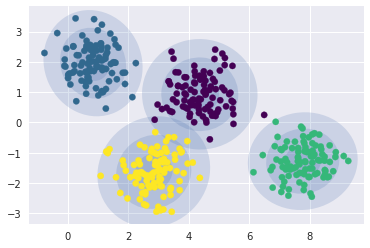

In [11]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Now use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters.

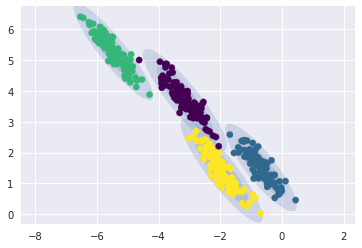

In [12]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This indicates that GMM solves the two main issues with *k*-means.

### Choosing the covariance type

The ``covariance_type`` option was set differently for each previous example. It controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.

The default is ``covariance_type="diag"`` - __the size of the cluster along each dimension can be set independently__. The resulting ellipse is constrained to align with the axes.

``covariance_type="spherical"`` is a simpler option. __It constrains the shape of the cluster such that all dimensions are equal__. The resulting clusters will be similar to that of *k*-means, but not equivalent.

``covariance_type="full"`` - __each cluster to be modeled as an ellipse with arbitrary orientation__. It is a more complicated and computationally expensive model, especially as the number of dimensions grows.

![(Covariance Type)](05.12-covariance-type.png)

### GMM as a Density Estimator

Though GMM is often used as a clustering algorithm, __it fundamentally is a density estimator__. 

The result of a GMM fit __is a generative probabilistic model__ describing the distribution of the data.

Consider data generated from Scikit's ``make_moons`` function.

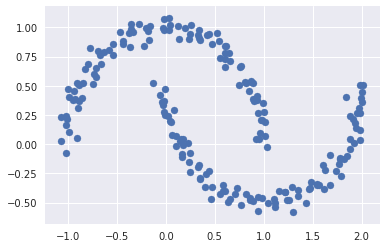

In [13]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

A two-component GMM as a clustering model doesn't help.

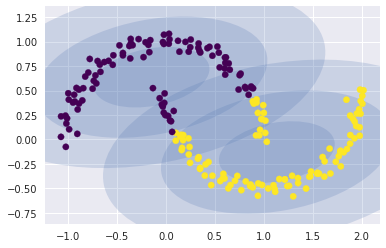

In [14]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

If we use more components and ignore the cluster labels, the result is much better.

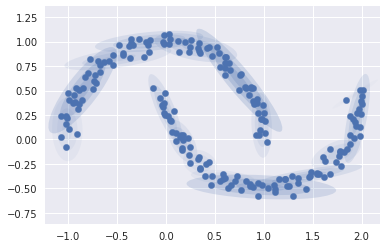

In [15]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

The mix of 16 Gaussians is not meant to find clusters. __It is meant to model the *distribution* of the data__.

This is a generative model of the distribution. GMM gives us a recipe to generate random data distributed similarly to our input. Here are 400 new points drawn from this 16-component GMM fit to our original data:

In [39]:
Xnew = gmm16.sample(400) # returns X : array,shape(n_samples, n_features)
                         #         y : array,shape (nsamples,)

#Xnew[0].size, Xnew[1].size, Xnew[0][0], Xnew[1][0], Xnew[0][1]

plt.scatter(Xnew[:, 0], Xnew[:, 1]);

TypeError: tuple indices must be integers or slices, not tuple

### How many components?

GMM gives us a means of finding the optimal number of components for a given dataset. A generative model is inherently a probability distribution - __we can evaluate the *likelihood* of the dataset, using cross-validation to avoid over-fitting__.

We can also avoid overfitting by adjusting model likelihoods using a criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion). Scikit's ``GMM`` estimator includes built-in methods that compute both of these criteria.

Let's __plot AIC and BIC vs the number of GMM components__ for our moon dataset:

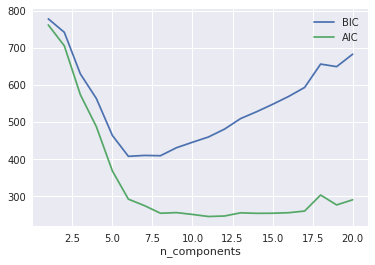

In [42]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The __optimal number of clusters minimizes AIC or BIC__. 

__AIC says 16 components was too many__ - 8-12 components would have been better. As is typical with this sort of problem, the __BIC recommends a simpler model__.

The choice of number of components __measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*__. Use it for clustering only when warranted within simple datasets.

### Example: GMM for Generating New Data

We have seen GMM being used as a generative model to create new samples from a distribution defined by the input data. __Use this idea to generate *new handwritten digits* from the digits dataset.__

In [43]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Plot the first 100 digits.

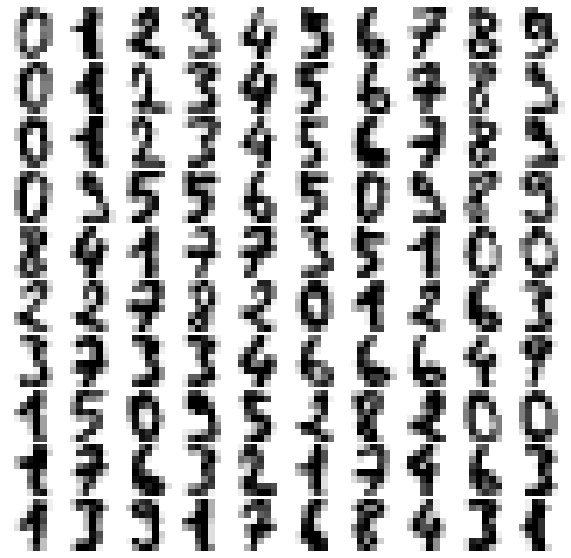

In [45]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(10,10),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions; we can build a GMM on top of these to generate more.

__GMMs can have difficulty converging in such a high dimensional space__. Start with an __invertible__ dimensionality reduction algorithm on the data. __Use PCA & ask it to preserve 99% of the variance in the projected data.__

In [46]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss. Use the AIC to estimate how many GMM components we should use.

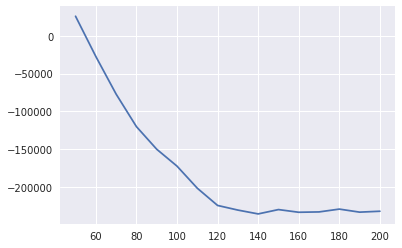

In [47]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It looks like ~120 components minimizes the AIC. Fit this to the data and confirm that it has converged.

In [48]:
gmm = GaussianMixture(120, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model.

In [49]:
data_new = gmm.sample(100)
data_new

(array([[-0.09130258, -0.87396989, -1.9212555 , ...,  0.60191123,
         -0.34596298, -1.02673968],
        [ 0.07389689,  1.28829672, -0.0723728 , ..., -1.46436675,
         -2.15743039, -0.32240342],
        [ 1.61653606,  0.07332833, -1.16489755, ...,  0.52416176,
         -0.2722092 ,  2.51283297],
        ..., 
        [ 0.04697409,  1.05130853, -0.86905267, ..., -1.09798208,
         -0.43972293, -0.33153618],
        [-0.4053193 , -1.19970968, -0.51811615, ...,  0.58226268,
          0.66095496,  0.79991606],
        [-0.70854909, -1.31081992, -0.53921691, ...,  1.39342991,
          0.61319365, -0.900474  ]]),
 array([  1,   2,   3,   5,   6,   7,   7,   8,   8,   8,   8,   9,  10,
         10,  11,  13,  13,  17,  17,  17,  18,  18,  19,  20,  20,  21,
         22,  23,  25,  27,  27,  28,  31,  32,  35,  37,  38,  38,  38,
         39,  40,  42,  44,  45,  49,  50,  52,  52,  52,  56,  58,  65,
         66,  66,  68,  68,  68,  70,  70,  70,  70,  71,  72,  72,  72,
       

Use the inverse transform of the PCA object to construct the new digits:

In [50]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

ValueError: could not broadcast input array from shape (100,41) into shape (100)

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.
Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier, as we shall see in the next section.